In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maternal-and-child-health-monitoring-in-lmics/training_label.csv
/kaggle/input/maternal-and-child-health-monitoring-in-lmics/sample submission.csv
/kaggle/input/maternal-and-child-health-monitoring-in-lmics/gee_features.csv
/kaggle/input/selecting-features-using-tree/y_train.csv
/kaggle/input/selecting-features-using-tree/x_train.csv
/kaggle/input/selecting-features-using-tree/__results__.html
/kaggle/input/selecting-features-using-tree/x_submission.csv
/kaggle/input/selecting-features-using-tree/__notebook__.ipynb
/kaggle/input/selecting-features-using-tree/DHSID.csv
/kaggle/input/selecting-features-using-tree/__output__.json
/kaggle/input/selecting-features-using-tree/custom.css


Required libraries and packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import tqdm
from scipy import stats
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import pearsonr

Checking whether cuda is available or not

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE IS ... ", device)

DEVICE IS ...  cpu


Number of epochs, learning rate, batch size

In [6]:
epochs = 10
lr = 1e-4
batch_size = 32

Loading the dataset

In [7]:
x_train = pd.read_csv('/kaggle/input/selecting-features-using-tree/x_train.csv')
y_train = pd.read_csv('/kaggle/input/selecting-features-using-tree/y_train.csv')
x_submission = pd.read_csv('/kaggle/input/selecting-features-using-tree/x_submission.csv')
DHSID = pd.read_csv('/kaggle/input/selecting-features-using-tree/DHSID.csv')

Normalizing the data fro training, we are merging the x_train and x_submission and normalizing them using min max scaler

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Stack the DataFrames vertically
merged_df = pd.concat([x_train, x_submission], axis=0)

# Separate the column names from the DataFrame
column_names = merged_df.columns.tolist()

scaled_data = scaler.fit_transform(merged_df)

scaled_df = pd.DataFrame(scaled_data, columns=column_names)

In [9]:
# Separating the DataFrame back into the original parts
x_train_scaled = scaled_df[:len(x_train)]
x_submission_scaled = scaled_df[len(x_train):]

Dividing the data into train,test and validation for analysis

In [10]:
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Splitting the data into train and test sets based on country (80% train, 20% test)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train_scaled, y_train, test_size=0.2, stratify = x_train_scaled["key1"])

# Splitting the train set into train and val sets based on country (75% train, 25% dev)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.25, stratify = x_train1["key1"])

In [11]:
x_train1.shape

(46768, 2000)

In [12]:
y_train1.shape

(46768, 6)

In [13]:
x_test1.shape

(15590, 2000)

In [14]:
x_val1.shape

(15590, 2000)

In [15]:
def collate_fn(x,y):
    '''
    Function to convert the data into tensors
    '''
    x_input = torch.tensor(x.values, dtype=torch.float32, device=device)
    y_array = y.values
    y_1 = torch.tensor(y_array[:,0], dtype=torch.float32, device=device) # Mean BMI
    y_2 = torch.tensor(y_array[:,1], dtype=torch.float32, device=device) # Median BMI
    y_3 = torch.tensor(y_array[:,2], dtype=torch.float32, device=device) # Unmet_Need_Rate
    y_4 = torch.tensor(y_array[:,3], dtype=torch.float32, device=device) # Under5_Mortality_Rate
    y_5 = torch.tensor(y_array[:,4], dtype=torch.float32, device=device) # Skilled_Birth_Attendant_Rate
    y_6 = torch.tensor(y_array[:,5], dtype=torch.float32, device=device) # Stunted_Rate
    
    # Returning the outputs
    return x_input, y_1, y_2, y_3, y_4, y_5, y_6

In [16]:
def create_data_loader(x,y):
    output_from_collate_fn = collate_fn(x,y)
    x = output_from_collate_fn[0]
    dataloader_1 = DataLoader(TensorDataset(x, output_from_collate_fn[1]), batch_size=batch_size, shuffle=True)
    dataloader_2 = DataLoader(TensorDataset(x, output_from_collate_fn[2]), batch_size=batch_size, shuffle=True)
    dataloader_3 = DataLoader(TensorDataset(x, output_from_collate_fn[3]), batch_size=batch_size, shuffle=True)
    dataloader_4 = DataLoader(TensorDataset(x, output_from_collate_fn[4]), batch_size=batch_size, shuffle=True)
    dataloader_5 = DataLoader(TensorDataset(x, output_from_collate_fn[5]), batch_size=batch_size, shuffle=True)
    dataloader_6 = DataLoader(TensorDataset(x, output_from_collate_fn[6]), batch_size=batch_size, shuffle=True)
    return dataloader_1, dataloader_2, dataloader_3, dataloader_4, dataloader_5, dataloader_6 

In [17]:
# Single task learning model

class SingleTaskLearn(nn.Module):
    def __init__(self,layers = [2000,512,256,128]):
        super().__init__()
        
        self.mlp_network = nn.Sequential(
            nn.Linear(layers[0], layers[1]), 
            nn.ReLU(),
            nn.Linear(layers[1], layers[2]), 
            nn.ReLU(),
            nn.Linear(layers[2], layers[3]),
        )

        self.last_layer = nn.Linear(
            layers[3], 1
        ) 

    def forward(self, x):
        x = self.mlp_network(x)
        output_x = self.last_layer(x)
        return output_x

In [18]:
def model_evaluation(dataloader, epochs, lr):
    
    model = SingleTaskLearn()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    
    loss_values = []

    for epoch in range(epochs):
        total_loss = 0.0
        predicted_values = []
        target_values = []

        for inputs, targets in dataloader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            
            predicted_values.extend(outputs.detach().cpu().numpy())
            target_values.extend(targets.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


    # Plotting the loss graph
    plt.plot(range(1, epochs + 1), loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss with Epochs")
    plt.show()
    
    return model

In [19]:
model = SingleTaskLearn()

In [20]:
model.eval()

SingleTaskLearn(
  (mlp_network): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (last_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
y_train.columns

Index(['Mean_BMI', 'Median_BMI', 'Unmet_Need_Rate', 'Under5_Mortality_Rate',
       'Skilled_Birth_Attendant_Rate', 'Stunted_Rate'],
      dtype='object')

In [22]:
def model_testing(dataloader, model):
    model.eval()
    predicted_values = []
    target_values = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predicted_values.extend(outputs.cpu().numpy())
            target_values.extend(targets.cpu().numpy())

    return predicted_values, target_values

In [23]:
def calculate_squared_pearson_r2(predicted_values, target_values):
    predicted_values = np.array(predicted_values).flatten()
    pearson_corr, _ = pearsonr(predicted_values, target_values)
    return pearson_corr ** 2

In [24]:
def model_showing(x_train, y_train, x_val, y_val, x_test, y_test):
    
    dataloader_train = create_data_loader(x_train, y_train)
    dataloader_val = create_data_loader(x_val, y_val)  
    dataloader_test = create_data_loader(x_test, y_test)
    models = []

    for i in range(6):
        print('Training of column {}'.format(i))
        model = model_evaluation(dataloader_train[i], epochs=epochs, lr=lr)
        models.append(model)

        # Making predictions on the validation set
        predicted_values1, target_values1 = model_testing(dataloader_val[i], model)
        r2 = calculate_squared_pearson_r2(predicted_values1, target_values1)
        print('r2 value of column{} of val set is {}'.format(i,r2))

        # Making predictions on the test set
        predicted_values2, target_values2 = model_testing(dataloader_test[i], model)
        r2 = calculate_squared_pearson_r2(predicted_values2, target_values2)
        print('r2 value of column{} of test set is {}'.format(i,r2))

Training of column 0


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 39466.6639
Epoch 2/10, Loss: 15233.2796
Epoch 3/10, Loss: 15100.8261
Epoch 4/10, Loss: 15063.0408
Epoch 5/10, Loss: 14979.1088
Epoch 6/10, Loss: 14997.3858
Epoch 7/10, Loss: 14924.5201
Epoch 8/10, Loss: 14830.9426
Epoch 9/10, Loss: 14864.1380
Epoch 10/10, Loss: 14814.7088


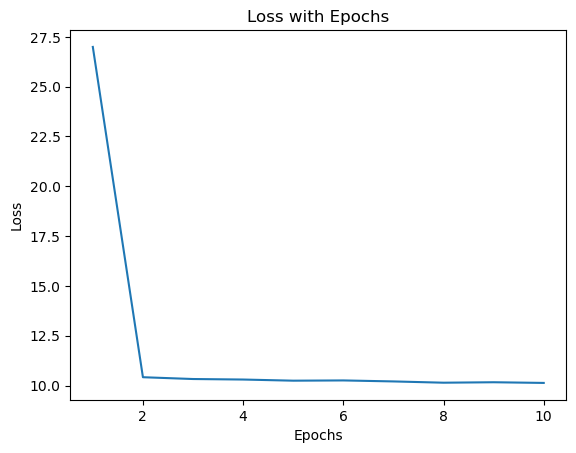

r2 value of column0 of val set is 0.013221325388399483
r2 value of column0 of test set is 0.01186923471446098
Training of column 1
Epoch 1/10, Loss: 40308.7932
Epoch 2/10, Loss: 15510.7513
Epoch 3/10, Loss: 15314.2081
Epoch 4/10, Loss: 15295.4243
Epoch 5/10, Loss: 15182.2103
Epoch 6/10, Loss: 15238.8861
Epoch 7/10, Loss: 15129.5739
Epoch 8/10, Loss: 15213.9160
Epoch 9/10, Loss: 15103.5532
Epoch 10/10, Loss: 15146.9418


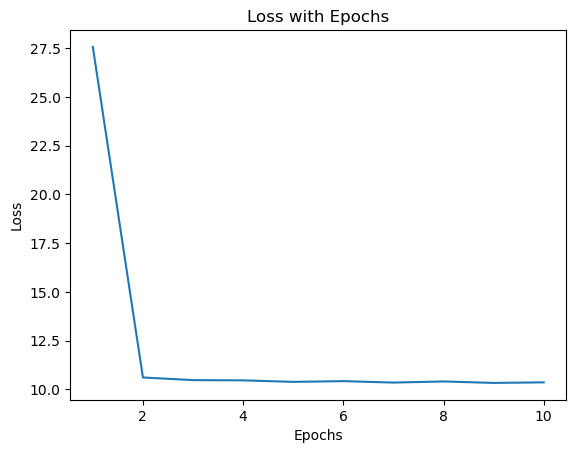

r2 value of column1 of val set is 0.022640548246492264
r2 value of column1 of test set is 0.021557526203599228
Training of column 2
Epoch 1/10, Loss: 1253912.3060
Epoch 2/10, Loss: 1179616.3375
Epoch 3/10, Loss: 1179087.0449
Epoch 4/10, Loss: 1178710.1022
Epoch 5/10, Loss: 1177966.4138
Epoch 6/10, Loss: 1177618.8141
Epoch 7/10, Loss: 1176967.0233
Epoch 8/10, Loss: 1176615.7277
Epoch 9/10, Loss: 1176803.2170
Epoch 10/10, Loss: 1177088.6463


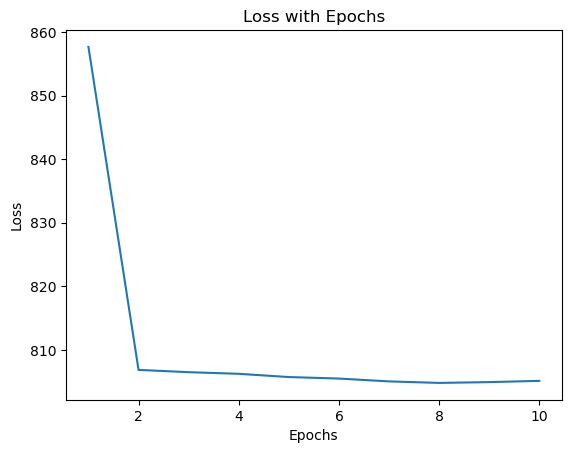

r2 value of column2 of val set is 0.052400712420583445
r2 value of column2 of test set is 0.04462027156730738
Training of column 3
Epoch 1/10, Loss: 63444.3824
Epoch 2/10, Loss: 60865.4883
Epoch 3/10, Loss: 60746.5504
Epoch 4/10, Loss: 60735.7581
Epoch 5/10, Loss: 60688.7263
Epoch 6/10, Loss: 60592.5101
Epoch 7/10, Loss: 60600.4752
Epoch 8/10, Loss: 60649.2428
Epoch 9/10, Loss: 60553.9728
Epoch 10/10, Loss: 60564.4076


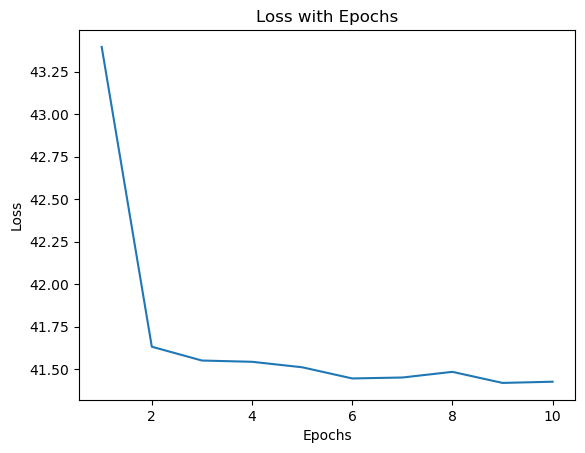

r2 value of column3 of val set is 0.06042968185456954
r2 value of column3 of test set is 0.05115807643313536
Training of column 4
Epoch 1/10, Loss: 1716272.0159
Epoch 2/10, Loss: 1455264.0081
Epoch 3/10, Loss: 1452853.2853
Epoch 4/10, Loss: 1453539.4509
Epoch 5/10, Loss: 1451018.6425
Epoch 6/10, Loss: 1450031.3732
Epoch 7/10, Loss: 1449557.7721
Epoch 8/10, Loss: 1450332.0805
Epoch 9/10, Loss: 1449841.5432
Epoch 10/10, Loss: 1449100.1101


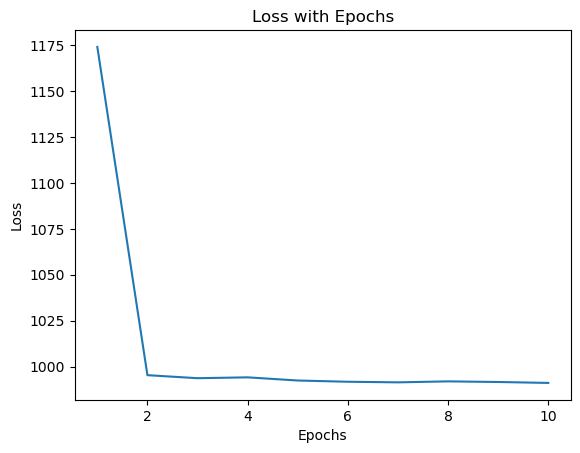

r2 value of column4 of val set is 0.036558309562432195
r2 value of column4 of test set is 0.036153671345115775
Training of column 5
Epoch 1/10, Loss: 428373.7001
Epoch 2/10, Loss: 392023.9670
Epoch 3/10, Loss: 392136.2413
Epoch 4/10, Loss: 391752.2960
Epoch 5/10, Loss: 391658.2955
Epoch 6/10, Loss: 391378.4739
Epoch 7/10, Loss: 391017.3544
Epoch 8/10, Loss: 391061.2523
Epoch 9/10, Loss: 390982.0181
Epoch 10/10, Loss: 391055.8951


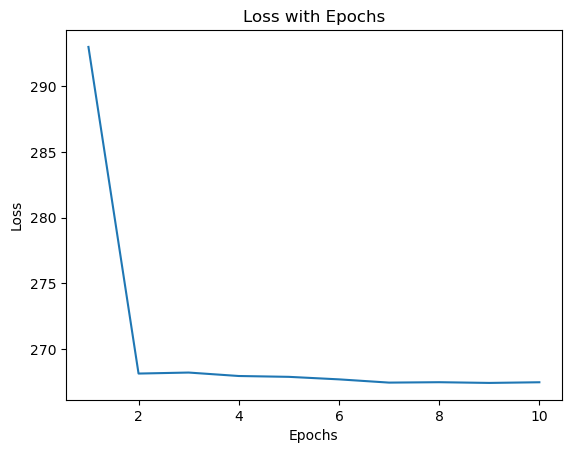

r2 value of column5 of val set is 0.08890893033962881
r2 value of column5 of test set is 0.07453212719788115


In [25]:
model_showing(x_train1, y_train1, x_val1, y_val1, x_test1, y_test1)

Predictions for **submission dataset**

In [26]:
x_submission = torch.tensor(x_submission_scaled.values,dtype = torch.float32, device=device)

In [27]:
# Initializing the models

model_1 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)

model_2 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=lr)

model_3 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=lr)

model_4 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=lr)

model_5 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=lr)

model_6 = SingleTaskLearn()
criterion = nn.MSELoss()
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=lr)

In [28]:
dataloader = create_data_loader(x_train_scaled,y_train)

In [29]:
dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fadc364fc10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fadc389c340>)

In [30]:
dataloader[0]

In [31]:
# Training loop
for epoch in range(epochs):
    # Train model 1
    model_1.train()
    for inputs, targets in dataloader[0]:
        optimizer_1.zero_grad()
        output_1 = model_1(inputs)
        loss_1 = criterion(output_1, targets)
        loss_1.backward()
        optimizer_1.step()

    # Train model 2
    model_2.train()
    for inputs, targets in dataloader[1]:
        optimizer_2.zero_grad()
        output_2 = model_2(inputs)
        loss_2 = criterion(output_2, targets)
        loss_2.backward()
        optimizer_2.step()

    # Train model 3
    model_3.train()
    for inputs, targets in dataloader[2]:
        optimizer_3.zero_grad()
        output_3 = model_3(inputs)
        loss_3 = criterion(output_3, targets)
        loss_3.backward()
        optimizer_3.step()

    # Train model 4
    model_4.train()
    for inputs, targets in dataloader[3]:
        optimizer_4.zero_grad()
        output_4 = model_4(inputs)
        loss_4 = criterion(output_4, targets)
        loss_4.backward()
        optimizer_4.step()

    # Train model 5
    model_5.train()
    for inputs, targets in dataloader[4]:
        optimizer_5.zero_grad()
        output_5 = model_5(inputs)
        loss_5 = criterion(output_5, targets)
        loss_5.backward()
        optimizer_5.step()

    # Train model 6
    model_6.train()
    for inputs, targets in dataloader[5]:
        optimizer_6.zero_grad()
        output_6 = model_6(inputs)
        loss_6 = criterion(output_6, targets)
        loss_6.backward()
        optimizer_6.step()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [32]:
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()
model_6.eval()

SingleTaskLearn(
  (mlp_network): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (last_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
# Predictions
with torch.no_grad():
        predictions_1 = model_1(x_submission)
        predictions_2 = model_2(x_submission)
        predictions_3 = model_3(x_submission)
        predictions_4 = model_4(x_submission)
        predictions_5 = model_5(x_submission)
        predictions_6 = model_6(x_submission)

In [34]:
predictions_1

tensor([[24.5555],
        [24.3394],
        [24.3943],
        ...,
        [23.9259],
        [24.3131],
        [23.8200]])

In [35]:
predictions_5

tensor([[62.1808],
        [62.3691],
        [62.4295],
        ...,
        [63.6905],
        [62.3441],
        [61.2382]])

#### 

In [36]:
column1 = predictions_1.numpy()
column2 = predictions_2.numpy()
column3 = predictions_3.numpy()
column4 = predictions_4.numpy()
column5 = predictions_5.numpy()
column6 = predictions_6.numpy()

In [37]:
y_train.columns.tolist()

['Mean_BMI',
 'Median_BMI',
 'Unmet_Need_Rate',
 'Under5_Mortality_Rate',
 'Skilled_Birth_Attendant_Rate',
 'Stunted_Rate']

In [38]:
# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    'Mean_BMI': column1.flatten(),
    'Median_BMI': column2.flatten(),
    'Unmet_Need_Rate': column3.flatten(),
    'Under5_Mortality_Rate': column4.flatten(),
    'Skilled_Birth_Attendant_Rate': column5.flatten(),
     'Stunted_Rate': column6.flatten()
})

In [40]:
# Concatenate the DataFrames horizontally
submission6 = pd.concat([DHSID, predictions_df], axis=1)

In [41]:
submission6.to_csv('submission6.csv',index = False)